# Exploratory Data Analysis: Drug Dataset

This notebook will take a look at exploratory analysis of the drug dataset from the American Gut Project. Start by reading processed drug data and processed microbiome data.

In [1]:
import pandas as pd
from skbio.diversity import alpha
from scipy.stats import f_oneway, kruskal, bartlett
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import matplotlib.pyplot as plt
import numpy as np

# gather drug data
drug = pd.read_csv(r'C:\Users\bwesterber\Desktop\Capstone\DSE-American-Gut-Project\drug_data\drugbank_drug_data.csv')

# gather microbiome data 
biom = pd.read_pickle(r'C:\Users\bwesterber\Downloads\cap_data_files\id_clean_biom.pkl')
biom = biom.fillna(0)

For each sample we will calculate the alpha diversity of the sample. For this example we calculate alpha diversity as the total number of unique OTUs in a given sample. 

In [2]:
# calculate alpha diversity for each observation

sample_ids = pd.DataFrame(biom['sample_id'])
biom = biom.drop(columns = ['sample_name', 'sample_id'])
biom = biom.values

alpha_diversities = []

for sample in range(len(biom)):
    alpha_diversities.append(alpha.observed_otus(biom[sample, :]))

del biom

Join the alpha diversity calculations to the drug data set:

In [3]:
sample_ids['alpha'] = alpha_diversities

#join with drug data
drug_alpha = sample_ids.merge(drug, how = 'inner', left_on = 'sample_id', right_on = 'sample_name')
drug_alpha = drug_alpha.groupby(['sample_id', 'ATC1', 'Fecal'], as_index = False)['alpha'].mean()

# Alpha Diversity By Level One ATC Class

For each level one ATC class lets compare the distribution of alpha values and see if any of them significantly differ from the rest. Let's first check to make sure variances are equal to see if ANOVA can be used for comparison. 

In [10]:
drug_classes = ['A', 'B', 'C', 'D', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'V']
distributions = []

for drug_class in drug_classes:
    distributions.append(drug_alpha['alpha'][drug_alpha['ATC1'] == drug_class].values)

statistic, p_value = bartlett(*[list(x) for x in distributions])
print('Bartlett Teset p value = ', p_value)

Bartlett Teset p value =  1.0452373283753758e-06


The Bartlett test tells us that the variances are not equivalent and we wont be able to use ANOVA for the comparison. Instead we will use Kruskal-Wallis H-test which is a non-parametric version of ANOVA. 

Text(0.5, 0, 'Level One ATC Class')

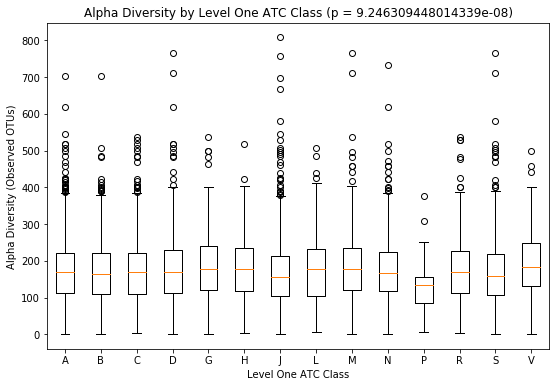

In [11]:
# determine if alpha diversity distributions are significnatly different using Kruskal-Wallis

statistic, p_value = kruskal(*[list(x) for x in distributions])

# plot
fig = plt.figure(figsize = (9, 6))

plt.boxplot(distributions, labels = drug_classes, showcaps = True, showbox = True)
plt.title('Alpha Diversity by Level One ATC Class (p = {})'.format(p_value, 'E'))
plt.ylabel('Alpha Diversity (Observed OTUs)')
plt.xlabel('Level One ATC Class')

With a low p-value we can conclude that at least one of these groups is significantly different than the others. Looking at the distributions classes P and J look to be slightly lower than average. The P and J classes represent 'Antiparasitic products, insecticides and repellents' and 'Antiinfectives for systemic use' respectively. This makes sense considering prior research has indicated that antibiotic use tends to be associated with lower alpha diversity. 

In order to determine which groups are different we will run Tukey HSD post hoc test.

In [5]:
# post hoc analysis

mc = MultiComparison(drug_alpha['alpha'], drug_alpha['ATC1'])
result = mc.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  A      B     0.6383  -14.1805  15.457 False 
  A      C    -1.2012  -13.2034 10.8011 False 
  A      D     4.3015  -10.2312 18.8342 False 
  A      G     8.5316  -5.0117  22.0749 False 
  A      H     5.4053  -9.8263   20.637 False 
  A      J    -7.4485  -19.294   4.397  False 
  A      L     4.7398  -17.6086 27.0883 False 
  A      M     9.0184  -5.3281  23.3649 False 
  A      N     0.143   -11.4413 11.7273 False 
  A      P    -43.184  -88.9955  2.6275 False 
  A      R     1.7986  -12.438  16.0353 False 
  A      S    -1.7245  -15.7836 12.3347 False 
  A      V    15.6539  -8.0693   39.377 False 
  B      C    -1.8394  -17.5358 13.8569 False 
  B      D     3.6632  -14.0432 21.3697 False 
  B      G     7.8934  -9.0105  24.7973 False 
  B      H     4.7671  -13.5174 23.0516 False 
  B      J    -8.0867  -23.6635   7.49  False 
  B      

As expected the P and J groups do have significant differences in alpha diversity with some of the other level one ATC classes. 

# Alpha Diversity by Drug Elimination Method

The next hypothesis will test is whether or not drugs that are eliminated fecally are associated with lower alpha diversity.

Text(0.5, 0, 'Drug Fecally Eliminated')

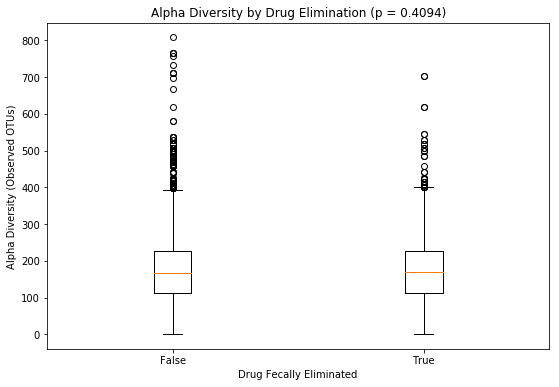

In [12]:
fecal_true = drug_alpha['alpha'][drug_alpha['Fecal'] == True].values
fecal_false =  drug_alpha['alpha'][drug_alpha['Fecal'] == False].values

# test for significance
statistic, p_value = f_oneway(fecal_true, fecal_false)

# plot
fig = plt.figure(figsize = (9, 6))

plt.boxplot([fecal_false, fecal_true], labels = ['False', 'True'], showcaps = True, showbox = True)
plt.title('Alpha Diversity by Drug Elimination (p = {})'.format(np.round(p_value, 4)))
plt.ylabel('Alpha Diversity (Observed OTUs)')
plt.xlabel('Drug Fecally Eliminated')

There appears to be no difference. Fail to reject null hypothesis. 